In [1]:
import mujoco
import cv2
import numpy as np
import yaml
import pickle
import pathlib
import pickle
import mujoco.viewer
from operator import index
import pinocchio as pin
from pinocchio.utils import *
import numpy as np
from numpy.linalg import norm, solve
import time
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm, markers
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ipywidgets import widgets, interact

In [37]:
class TrajOpt():
    def __init__(self, X, X_dot, X_ddot, t, goal):
        
        self.t = t
        self.dt = 0.05
        self.X = X
        self.X_dot = X_dot
        self.X_ddot = X_ddot
        self.goal = goal
        
        self.feature_length = self.X.shape[0]
        self.feature_count = self.X.shape[1]
        
        self.K = 50*np.identity(self.feature_count)
        self.D = 2*np.sqrt(self.K)
        self.conv_rate = 0.01
        self.alpha = -np.log(self.conv_rate)
        self.tau = self.t[-1]
        self.s = np.exp((-self.alpha/self.tau)*self.t)
        
        self.v = self.tau*self.X_dot
        self.v_dot = self.tau*self.X_ddot
        self.tau_v_dot = self.tau*self.v_dot
        
        self.K_inv = np.linalg.inv(self.K)

        self.theta = None

        self.Dv = np.zeros(shape=self.X.shape)
        for i in range(self.feature_length):
            self.Dv[i] = self.D@self.v[i]
        
        self.f_target = np.zeros(shape=self.X.shape)
        for i in range(self.feature_length):
            self.f_target[i] = self.tau_v_dot[i] + self.Dv[i] + self.K@(self.X[i] - self.goal)

    def learn_weights(self):
        # ci= np.logspace(-3, 0, num=self.bf_number)
        # h = self.bf_number / (ci ** 2)
        # ci_tile = np.tile(ci[None],(self.feature_length,1))
        # s = np.tile(self.s[:,None], (1, self.bf_number))
        # self.psi_matrix = np.exp(-h * (s - ci_tile) ** 2)
        # self.inv_sum_bfs = 1.0 / np.sum(self.psi_matrix, axis=-1)
        
        # self.bf_target = np.einsum('lb,l->lb',self.psi_matrix*s,self.inv_sum_bfs)

        self.bf_target = np.zeros(shape=(self.feature_length,self.feature_length))
        for i in range(self.feature_length):
            self.bf_target[i,i] = 1
        print(self.bf_target.shape)
        print(self.f_target.shape)
        sol = np.linalg.lstsq(self.bf_target,self.f_target,rcond=None)
        self.theta = sol[0]
        print('Theta is leaned using LWR. Shape => ', self.theta.shape)

    def get_theta(self):
        return self.theta

    def set_theta(self, value):
        self.theta = value

    def get_g(self, ind):
        return self.bf_target[ind]

    def get_g_all(self):
        return self.bf_target

    def get_f(self):
        return self.f_target
    
    def rollout(self, x, x_dot, theta, ind):
        # f = self.psi_matrix[ind]@theta
        # f *= self.inv_sum_bfs[ind]
        # f *= self.s[ind]

        f = self.bf_target[ind]@theta
        # f *= self.inv_sum_bfs[ind]
        f *= self.s[ind]

        v = self.tau * x_dot
        v_dot = (1.0 / self.tau) * (np.dot(self.K, self.goal - x) - np.dot(self.D, v) + f)
        v = v + v_dot * self.dt
        x_dot = v / self.tau
        x = x + x_dot * self.dt

        return x, x_dot

        
    

In [38]:
with open('../data.pkl', 'rb') as f:
    data = pickle.load(f)

t = data['time']
X = data['X']
X_dot = data['X_dot']
X_ddot = data['X_ddot']
x0 = data['x0']
goal = data['goal']
num_g = data['num_g']
num_data = data['num_data']
cost_mu = data['cost_mu']
cost_sigma = data['cost_sigma']
init_cost = data['cost']

ref = np.linspace(0,X.shape[1]-1,200,dtype=int)
demo_num = 4
t = t[demo_num,ref]
X = X[demo_num,ref,:]
X_dot = X_dot[demo_num,ref,:]
X_ddot = X_ddot[demo_num,ref,:]
feature_length = X.shape[0]
feature_count = X.shape[1]

In [39]:
traj = TrajOpt(X, X_dot, X_ddot, t, goal)
traj.learn_weights()
weights = traj.get_theta()
f = traj.get_f()
g = traj.get_g_all()

(200, 200)
(200, 2)
Theta is leaned using LWR. Shape =>  (200, 2)


In [40]:
x_roll = np.zeros(shape=X.shape)
xd_roll = np.zeros(shape=X_dot.shape)
for i in range(feature_length):
    if i == 0:
        x_roll[i]=x0
        xd_roll[i] =X_dot[0] 
    else:
        x,xd = traj.rollout(x_roll[i-1],xd_roll[i-1],weights,i)
        x_roll[i]=x
        xd_roll[i]=xd

        


# wg = np.einsum('ij,jk->ik',g,weights)
# wg.shape
# fwg = f+wg
# plt.plot(t,wg[:,0])
# plt.plot(t,f[:,0])

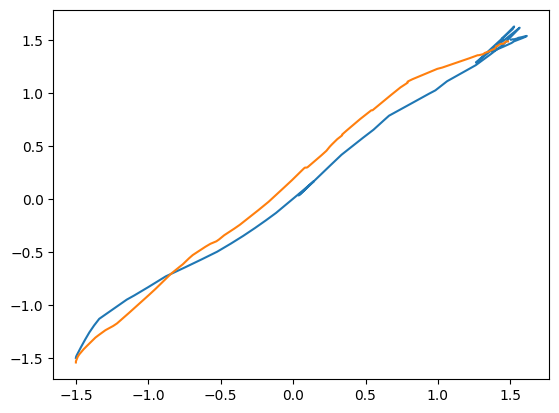

In [41]:
plt.plot(x_roll[:,0],x_roll[:,1])
plt.plot(X[:,0],X[:,1])